
=== n=0 ===
Counts: {'111': 77, '101': 55, '110': 66, '000': 57, '010': 53, '100': 75, '011': 67, '001': 62}


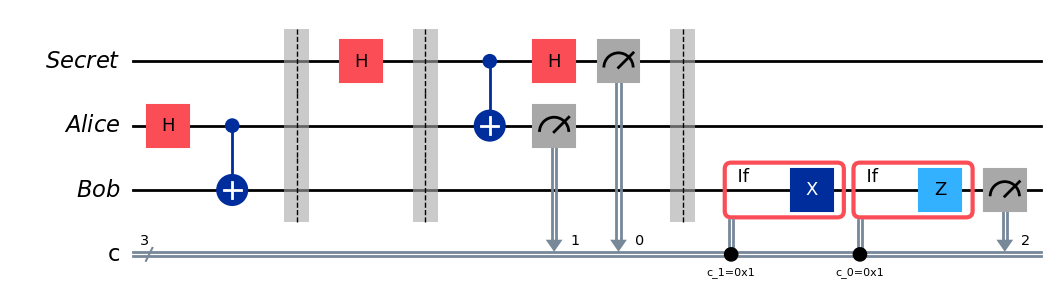


=== n=1 ===
Counts: {'101': 67, '100': 73, '110': 64, '000': 50, '011': 70, '111': 61, '001': 57, '010': 70}


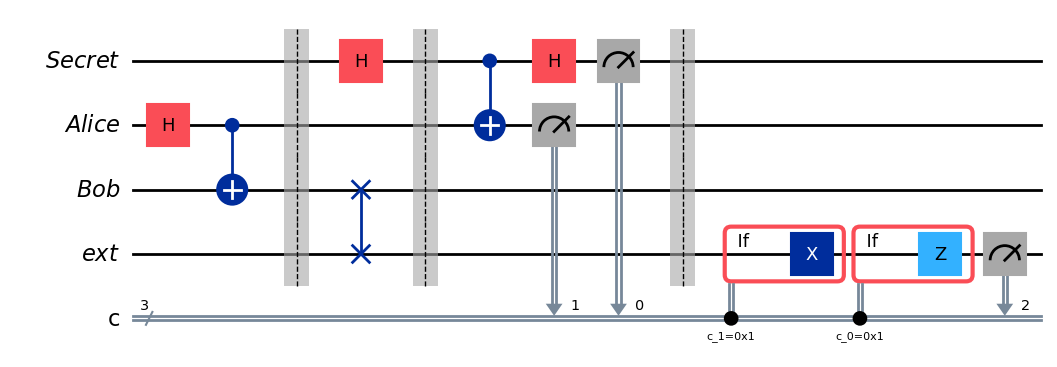

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

backend = AerSimulator()

def function_tel_tomography_test(n=0, shots=2048):
    Alice  = QuantumRegister(1, 'Alice')
    Bob    = QuantumRegister(1, 'Bob')
    Secret = QuantumRegister(1, 'Secret')
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        qc = QuantumCircuit(Secret, Alice, Bob, ext)
    else:
        qc = QuantumCircuit(Secret, Alice, Bob)

    c = ClassicalRegister(3, 'c')
    qc.add_register(c)

    # Par EPR
    qc.h(Alice)
    qc.cx(Alice, Bob)
    qc.barrier()

    # Swaps
    if n > 0:
        qc.swap(Bob[0], ext[0])
        for i in range(1, n):
            qc.swap(ext[i-1], ext[i])
        target = ext[n-1]
    else:
        target = Bob[0]

    # Estado secreto |+>
    qc.h(Secret)
    qc.barrier()

    # Bell measurement
    qc.cx(Secret, Alice)
    qc.h(Secret)
    qc.measure(Secret, c[0])
    qc.measure(Alice,  c[1])
    qc.barrier()

    # Correções condicionais (sem noise model)
    with qc.if_test((c[1], 1)):
        qc.x(target)
    with qc.if_test((c[0], 1)):
        qc.z(target)

    # Tomografia: apenas em Z (pra inspecionar counts)
    qc.measure(target, c[2])

    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts()

    return counts, qc

# Testes
for n in [0,1]:
    counts, qc = function_tel_tomography_test(n=n, shots=512)
    print(f"\n=== n={n} ===")
    print("Counts:", counts)
    display(qc.draw('mpl'))
